In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_IP_OOP")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    for i in range(1, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)
    return np.mean(periods)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_IP_OOP


In [2]:
def plotspectrum(data, fmax=1., filename=None, vlines=None):

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        for t in range(len(ps_plot)):
            break
            if ps_plot[t] > 0.006:
                print(fr[t], 1./fr[t], ps_plot[t])

        plt.plot(fr, ps_plot)

    if vlines is not None:
        plt.vlines(vlines, 0, 1, color="gray", linestyle=":")

    plt.xlim(-0.01,fmax)
    plt.ylim(0,1.3*np.amax(ps_plot))
    plt.ylim(0,0.22)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]


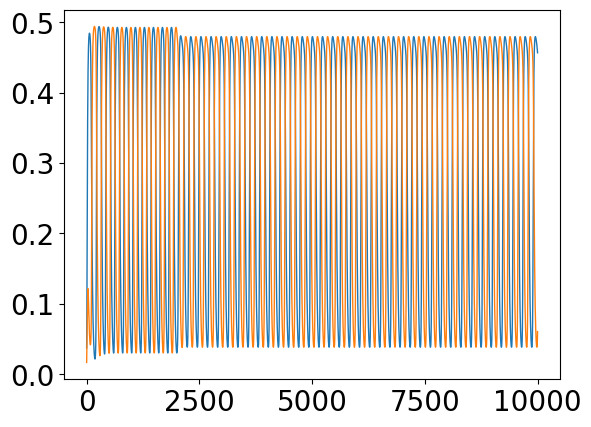

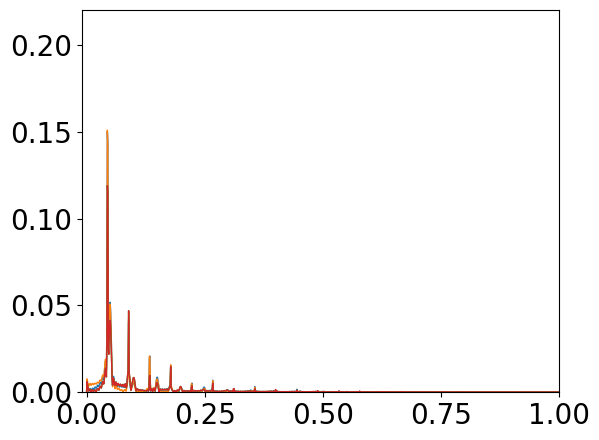

freq of max =  [0.0440088]
period of max =  [22.72272727]


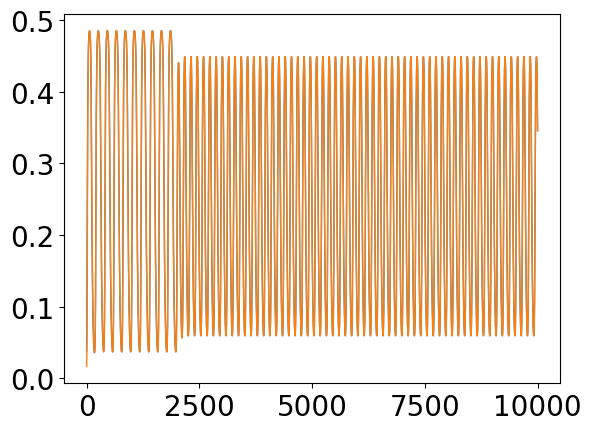

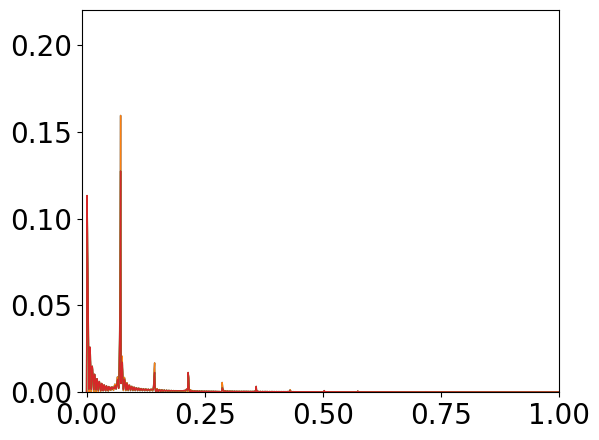

freq of max =  [0.0720144]
period of max =  [13.88611111]


In [3]:
coords = [1.8, 0.8]

coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

if True:
    data = dict()
    data = dict()
    data["coordinates"] = coords
    data["delay"] = 9.5

    data["control"] = [[None, None], [None, None], [None, None]]
    data["state"] = [[None, None], [None, None], [None, None]]
    data["init_state"] = [None, None]
    data["weight"] = [[1., 1.], [1., 1.], [1., 1.]]
    data["target_period"] = 0.
    data["init_range"] = [[None, None], [None, None], [None, None]]

duration = 1e3
dt = 0.1

inpdur = 200
sine = np.sin(2.*np.pi*np.arange(0,inpdur,dt)/20.)

test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,:int(inpdur/dt)] = 5.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,:int(inpdur/dt)] = -5.

test_input_phase = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_phase = np.vstack( ([test_input_phase]*N))
test_input_phase[0,:int(inpdur/dt)] = sine
test_input_phase[1,:int(inpdur/dt)] = - sine

test_inputin__phase = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_inputin__phase = np.vstack( ([test_input_phase]*N))
test_inputin__phase[0,:int(inpdur/dt)] = sine
test_inputin__phase[1,:int(inpdur/dt)] = sine

model = WCModel(Cmat=cmat, Dmat=data["delay"]*20.*cmat)

model.params['duration'] = duration
model.params.exc_ext_baseline = data["coordinates"][0]
model.params.inh_ext_baseline = data["coordinates"][1]
model.params.K_gl = coupling
nmaxdelay = model.getMaxDelay()

model.params["exc_ext"] = test_input_phase
model.run()

plt.plot(model.exc[0,:])
plt.plot(model.exc[1,:])
plt.show()

einit = np.zeros((N, nmaxdelay+1))
iinit = np.zeros((N, nmaxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n,-nmaxdelay-1:]
    iinit[n,:] = model.inh[n,-nmaxdelay-1:]

data["init_state"][0] = [einit, iinit]
tp0 = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

######################################################
model.params["exc_ext"] = test_inputin__phase
model.run()

plt.plot(model.exc[0,:])
plt.plot(model.exc[1,:])
plt.show()

einit = np.zeros((N, nmaxdelay+1))
iinit = np.zeros((N, nmaxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n,-nmaxdelay-1:]
    iinit[n,:] = model.inh[n,-nmaxdelay-1:]

data["init_state"][1] = [einit, iinit]

model.params["exc_ext"] = test_input_minus
model.run()

tp1 = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

data["target_period"] = [tp0, tp1]

In [4]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [5]:
from numba.typed import Dict
from numba.core import types

weights_dict = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights_dict["w_2"] = 1.0
weights_dict["w_1"] = 0.0
weights_dict["w_1T"] = 0.0
weights_dict["w_1D"] = 0.0

In [230]:
with open(os.path.join(pickledir, '2n_wc_IP_OOP.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [6]:
with open(os.path.join(pickledir, '2n_wc_IP_OOP.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['coordinates', 'delay', 'control', 'state', 'init_state', 'weight', 'target_period', 'init_range'])


In [7]:
print(data["weight"])

[[15.546739633193967, 7.564646025110232], [0.7586123822724321, -2.443691976309064], [11.6461648115058, -3.979760303720948]]


In [8]:
y0lim = [0, 0.6]

def plot_control_bi(state, control, dur, dt,filename=None, title=None, coc=-1):
    fig, ax = plt.subplots(2,1, figsize=(16,8), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cols = ["red", "black"]
    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0].plot(time_array, state[n,0,:], color=cols[n], label="E{}".format(n), linestyle=ls[n])
        ax[1].plot(time_array, control[n,0,:], color=cols[n],  linestyle=ls[n])

    ax[0].legend(loc="upper right")

    if coc >=0:
        ax[1].text(0.72, 0.85, "Cost of control = {:.4f}".format(coc), transform=ax[1].transAxes)

    ax[0].set_xlim(0, dur)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    
    fig.align_ylabels([ax[:]])
    
    if title is not None:
        ax[0].set_title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [9]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

maxstr = 5
pr = np.arange(0,101,10)

In [10]:
def set_standard_weight(model_controlled, method, i_init):
    if method == 0 and i_init == 0:
        model_controlled.weights["w_f_sync"] = 1
    elif method == 0 and i_init == 1:
        model_controlled.weights["w_f"] = 1
    elif method == 1 and i_init == 0:
        model_controlled.weights["w_cc"] = 1
    elif method == 1 and i_init == 1:
        model_controlled.weights["w_cc"] = -1
    elif method == 2 and i_init == 0:
        model_controlled.weights["w_var"] = 1
    elif method == 2 and i_init == 1:
        model_controlled.weights["w_var"] = -1

    return

def set_weight(model_controlled, method, i_init, weight_array):
    if method == 0 and i_init == 0:
        model_controlled.weights["w_f_sync"] = weight_array[method][i_init]
    elif method == 0 and i_init == 1:
        model_controlled.weights["w_f"] = weight_array[method][i_init]
    elif method == 1 and i_init == 0:
        model_controlled.weights["w_cc"] = weight_array[method][i_init]
    elif method == 1 and i_init == 1:
        model_controlled.weights["w_cc"] = weight_array[method][i_init]
    elif method == 2 and i_init == 0:
        model_controlled.weights["w_var"] = weight_array[method][i_init]
    elif method == 2 and i_init == 1:
        model_controlled.weights["w_var"] = weight_array[method][i_init]

In [11]:
data["weight"][0][0] = 4000.
data["weight"][0][1] = 1000.
data["weight"][1][0] = 1000.
data["weight"][1][1] = -2000.
data["weight"][2][0] = 15000.
data["weight"][2][1] = -1000.

data["init_range"][0][0] = [0,2,4]
data["init_range"][0][1] = [0,2]
data["init_range"][1][0] = [0,2]
data["init_range"][1][1] = [-2,-1]
data["init_range"][2][0] = [6]
data["init_range"][2][1] = [4]

In [53]:
data["control"][0][0] = data["control"][2][0].copy()
data["control"][0][1] = data["control"][2][1].copy()

data["control"][1][0] = data["control"][2][0].copy()
data["control"][1][1] = data["control"][2][1].copy()

In [63]:
with open(os.path.join(pickledir, '2n_wc_IP_OOP.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [58]:
with open(os.path.join(pickledir, '2n_wc_IP_OOP.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['coordinates', 'delay', 'control', 'state', 'init_state', 'weight', 'target_period', 'init_range'])


In [ ]:
data["weight"][0][0] *= 4.
data["weight"][0][1] *= 2.

shift period =  13.886111111111111
target period, max delay =  22.722727272727273 95
Optimal control with target oscillation period
UNCONTROLLED COST =  0.2499999999999991
Compute control for a deterministic system
Cost in iteration 0: -0.14590318637134442
Final cost : -0.14590318637134442
fsync, ucc, coc =  0.20519360143342955 0.2499999999999991 0.11314331513068178
weight =  -1.2625869300346366
Compute control for a deterministic system
Cost in iteration 0: -0.14593144416590242
Final cost : -0.14593144416590242
Compute control for a deterministic system
Cost in iteration 0: -0.14593144416590242
Converged in iteration 9 with cost -0.1459314568949076
Final cost : -0.1459314568949076
Compute control for a deterministic system
Cost in iteration 0: -0.1459314568949076
Converged in iteration 7 with cost -0.14593145689490883
Final cost : -0.14593145689490883
Compute control for a deterministic system
Cost in iteration 0: -0.14593145689490883
Converged in iteration 2 with cost -0.145931456894

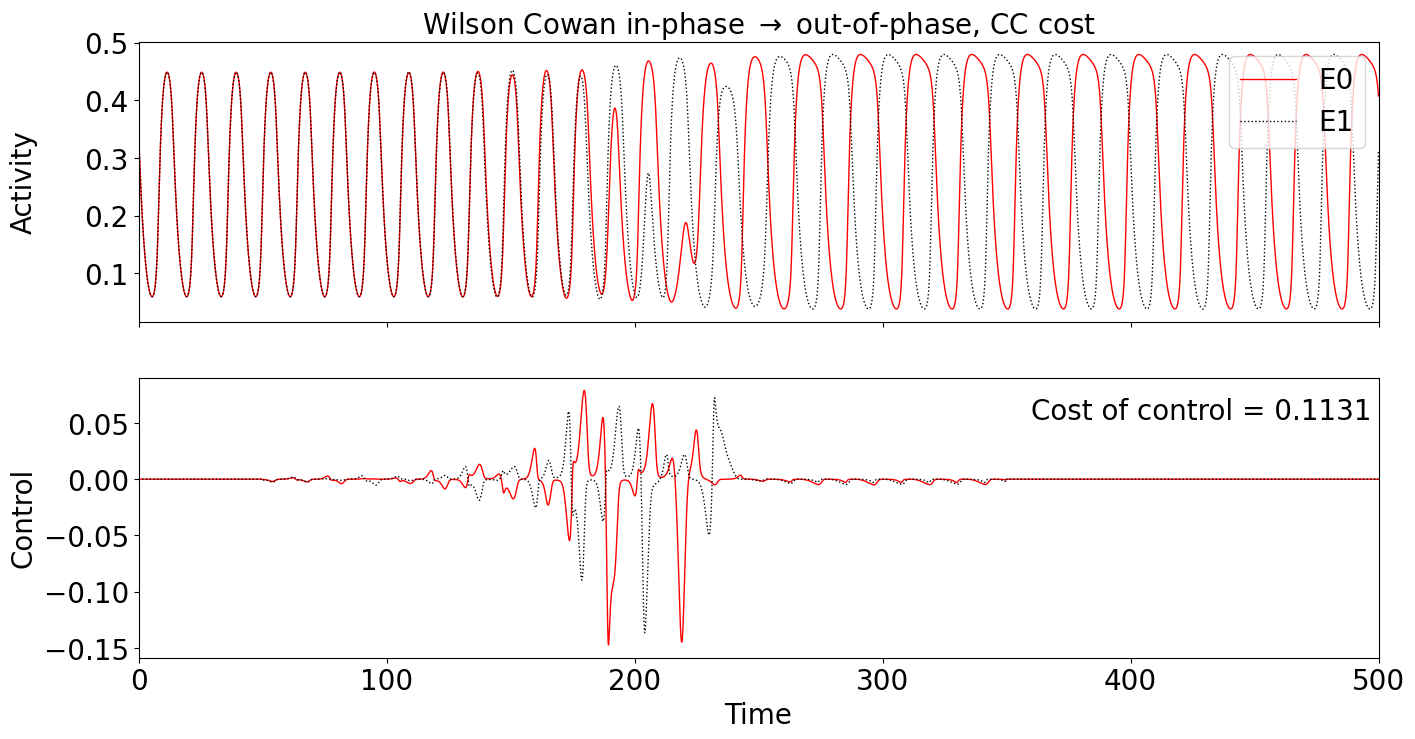

shift period =  13.886111111111111
target period, max delay =  22.722727272727273 95
Optimal control with target oscillation period
UNCONTROLLED COST =  0.0
Compute control for a deterministic system
Cost in iteration 0: -1.1094088324392626e-07
Final cost : -1.1094088324392626e-07
fsync, ucc, coc =  0.02739956707339323 0.0 0.11094088334902207
weight =  -4.049005372703
Compute control for a deterministic system
Cost in iteration 0: -1.1094088343821529e-07
Final cost : -1.1094088343821529e-07
Compute control for a deterministic system
Cost in iteration 0: -1.1094088343821529e-07
Converged in iteration 1 with cost -1.1094088343821529e-07
Final cost : -1.1094088343821529e-07
Compute control for a deterministic system
Cost in iteration 0: -1.1094088343821529e-07
Converged in iteration 1 with cost -1.1094088343821529e-07
Final cost : -1.1094088343821529e-07
Compute control for a deterministic system
Cost in iteration 0: -1.1094088343821529e-07
Converged in iteration 1 with cost -1.1094088343

In [67]:
it = 10
duration = 500
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

int0 = 500
int1 = 3500
int2 = 2000

for method in [0,1,2]:
    for i_init in range(2):

        if i_init not in [1]: continue
        if method not in [1,2]: continue

        target_period_index = 1
        shift_period_index = 1
        if i_init == 1:
            target_period_index = 0
        else:
            shift_period_index = 0

        target_period = data["target_period"][target_period_index]
        shift_period = data["target_period"][shift_period_index]

        print("shift period = ", shift_period)

        #if i_init == 1:
        #    target_period *= 0.5

        model = WCModel(Cmat=cmat, Dmat=data["delay"]*20.*cmat)
        nmaxdelay = model.getMaxDelay()
        print("target period, max delay = ", target_period, nmaxdelay)

        model.params["exc_ext_baseline"] =  data["coordinates"][0]
        model.params["inh_ext_baseline"] =  data["coordinates"][1]
        model.params.K_gl = coupling
            
        model.params.duration = duration
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]

        model.params["exc_init"] = data["init_state"][i_init][0]
        model.params["inh_init"] = data["init_state"][i_init][1]

        model.run()

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.maximum_control_strength = maxstr
        
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = 1.

        set_standard_weight(model_controlled, method, i_init)
        ucc = model_controlled.compute_total_cost()
        print("UNCONTROLLED COST = ", ucc)

        set_weight(model_controlled, method, i_init, data["weight"])

        if True:
            if type(data["control"][method][i_init]) != type(None):
                #model_controlled.control[:,0,:-int(np.floor(1*shift_period/dt)):] = data["control"][method][i_init][:,0,int(np.floor(1*shift_period/dt)):]  # shift back
                #model_controlled.control[:,0,int(2*shift_period/dt):] = data["control"][method][i_init][:,0,:-int(2*shift_period/dt)] # shift forward
                model_controlled.control = data["control"][method][i_init].copy()
                model_controlled.update_input()

        elif method == 2 and i_init ==1:
            c_in = np.zeros((zero_control.shape))
            for t in range(int0+1, int1, 1):
                c_in[0,0,t] = c_in[0,0,t-1] + 0.001 * (np.random.rand(1)-0.5)
                c_in[1,0,t] = c_in[1,0,t-1] + 0.001 * (np.random.rand(1)-0.5)

            model_controlled.control = c_in
            model_controlled.update_input()

        model_controlled.optimize(0)
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True
        
        for l in range(0):
            for k in data["init_range"][method][i_init]:
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**int(k)
                model_controlled.optimize(2)

        itnumber = 40
        #if method == 0: itnumber = 4
        #if method == 2 and i_init == 1: itnumber = 1

        for j in range(itnumber):

            if True:
                coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights_dict, dt)
                F = model_controlled.compute_total_cost()
                fsync = (F - coc)/data["weight"][method][i_init]
                data["weight"][method][i_init] = coc/ (ucc*(1-1e-6) - fsync)
                if method == 1 and i_init == 1:
                    data["weight"][method][i_init] = -0.5*coc/ (ucc*(1-1e-6) - fsync)
                elif method == 2 and i_init == 1:
                    data["weight"][method][i_init] = -(1. + 1e-6) * coc/ fsync
                print("fsync, ucc, coc = ", fsync, ucc, coc)
                #if np.abs(data["weight"][method][i_init]) < 1e-3:
                #    data["weight"][method][i_init] = np.sign(data["weight"][method][i_init]) * 1e-3
                print("weight = ", data["weight"][method][i_init])
                set_weight(model_controlled, method, i_init, data["weight"])

            model_controlled.optimize(0)
            model_controlled.grad_method = 0
            model_controlled.channelwise_optimization = True

            for l in range(1):
                for k in np.arange(-4, 4., 1.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

            model_controlled.grad_method = 1
            model_controlled.channelwise_optimization = True

            for l in range(1):
                for k in np.arange(-4, 4., 1.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(10)

            print("max grad = ", np.amax(np.abs(model_controlled.gradient)))

            coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights_dict, dt)
            print("final weight, final cost, cost of control = ", data["weight"][method][i_init], model_controlled.cost_history[-1], coc)

            if coc > 0.1:
                data["control"][method][i_init] = model_controlled.control.copy()
                data["state"][method][i_init] = model_controlled.get_xs()

        filename = os.path.join(dir, str(method) + "_" + str(i_init) + ".png")
        if i_init == 0:
            direction = r"out-of-phase $\rightarrow$ in-phase, "
        else:
            direction = r"in-phase $\rightarrow$ out-of-phase, "
        if method == 0:
            strmethod = "Fourier cost"
        elif method == 1:
            strmethod = "CC cost"
        elif method == 2:
            strmethod = "Variance cost"
        title = "Wilson Cowan " + direction + strmethod

        #with open(os.path.join(pickledir, '2n_wc_IP_OOP.pickle'), 'wb') as f:
        #    pickle.dump(data, f)
        
        plot_control_bi(model_controlled.get_xs(), model_controlled.control.copy(), duration, dt, filename=filename, title=title, coc=coc)

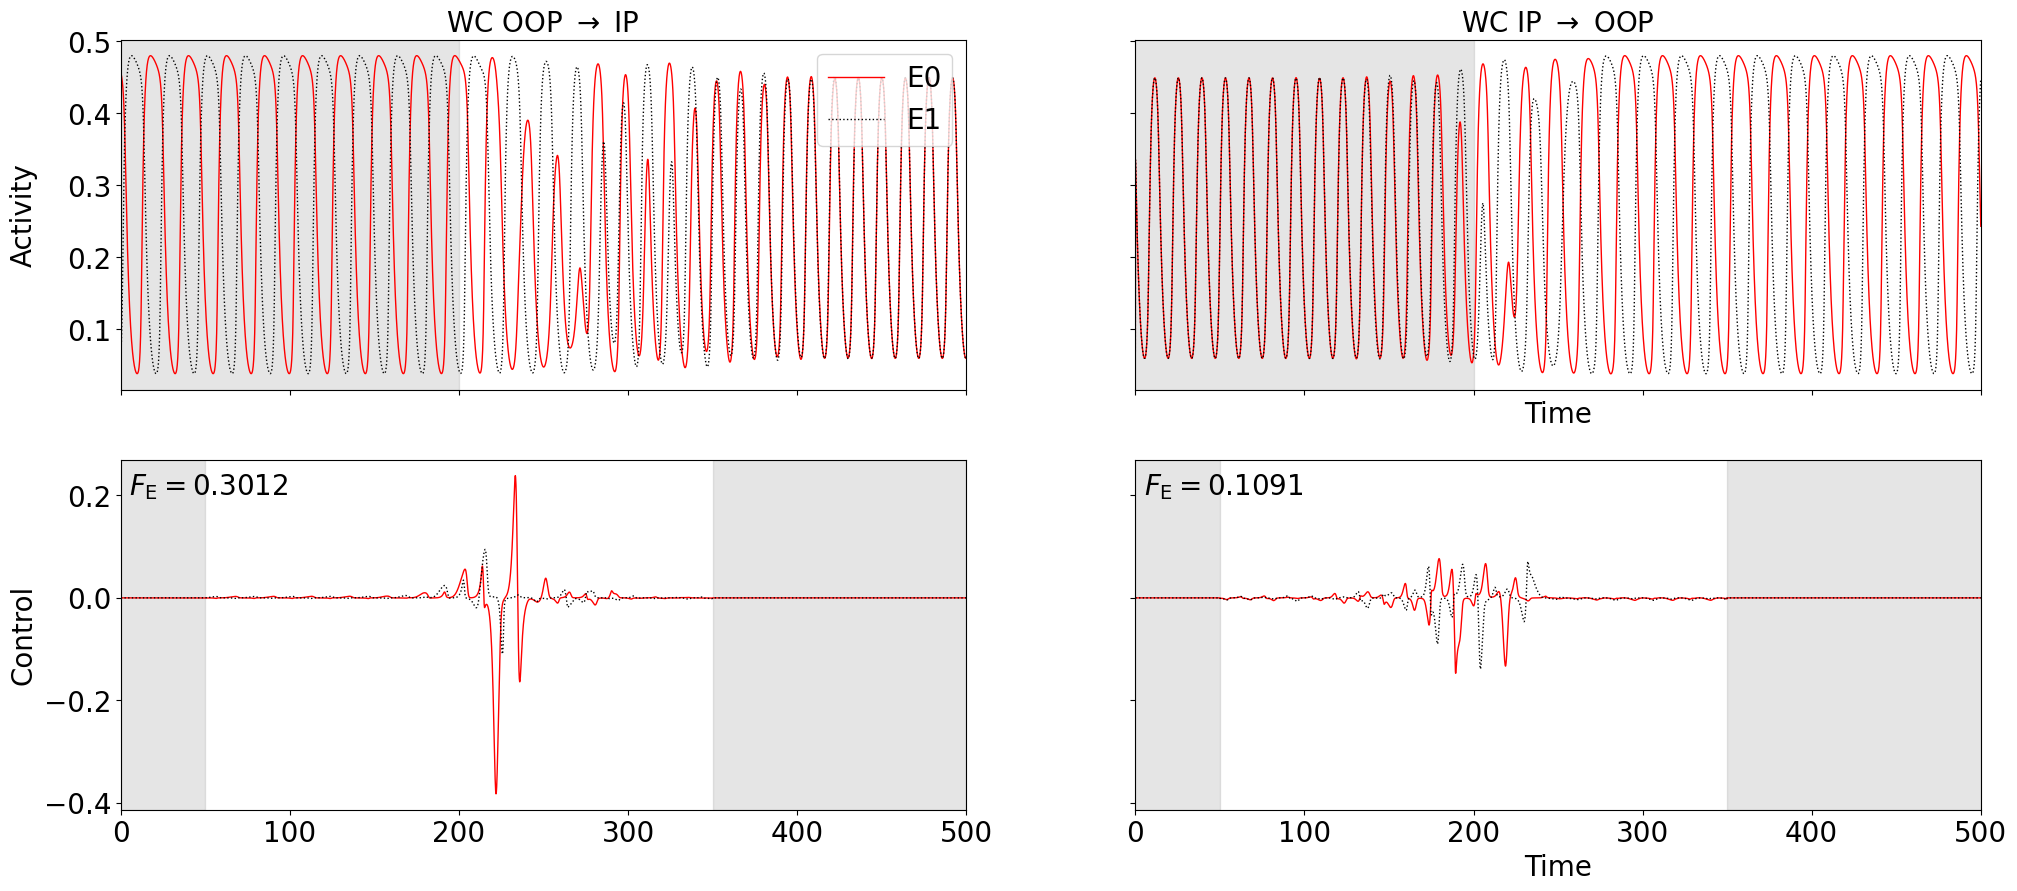

In [42]:
filename = os.path.join(dir, "WC_ss.pdf")

direction0 = r"OOP $\rightarrow$ IP "
direction1 = r"IP $\rightarrow$ OOP "

title = ["WC " + direction0, "WC " + direction1]

plot_control(duration, dt, filename, title)

In [41]:
y0lim = [0, 0.6]

def plot_control(dur, dt,filename, titles):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex=True, sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    cols = ["red", "black"]
    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0,0].plot(time_array, data["state"][0][0][n,0,:], color=cols[n], label="E{}".format(n), linestyle=ls[n])
        ax[1,0].plot(time_array, data["control"][0][0][n,0,:], color=cols[n],  linestyle=ls[n])
        ax[0,1].plot(time_array, data["state"][2][1][n,0,:], color=cols[n], linestyle=ls[n])
        ax[1,1].plot(time_array, data["control"][2][1][n,0,:], color=cols[n],  linestyle=ls[n])

    ax[0,0].legend(loc="upper right")

    ax[1,0].text(0.01, 0.9, r"$F_\text{E} = $" + "{0:.4f}".format(cost_functions.control_strength_cost(data["control"][0][0], weights_dict, dt)), transform=ax[1,0].transAxes)
    ax[1,1].text(0.01, 0.9, r"$F_\text{E} = $" + "{0:.4f}".format(cost_functions.control_strength_cost(data["control"][2][1], weights_dict, dt)), transform=ax[1,1].transAxes)

    ax[0,0].set_xlim(0, dur)

    ax[0,1].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")
    
    fig.align_ylabels([ax[:,0]])
    
    ax[0,0].set_title(title[0])
    ax[0,1].set_title(title[1])

    alpha=0.2
    for ci in range(2):
        ax[0,ci].axvspan(0, 200, color="grey", alpha=alpha)
        ax[1,ci].axvspan(350, 500, color="grey", alpha=alpha)
        ax[1,ci].axvspan(0, 50, color="grey", alpha=alpha)    

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return